In [1]:
%reload_ext autoreload
%autoreload 2
from cudants.io.image import Image, BatchedImages
from cudants.registration.rigid import RigidRegistration
from cudants.registration.affine import AffineRegistration
import torch
from torch.optim import SGD, Adam
from torch.nn import functional as F
from torch import nn
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [32]:
# img1 = Image.load_file('/data/rohitrango/BRATS2021/training/BraTS2021_00598/BraTS2021_00598_t1.nii.gz')
# img2 = Image.load_file('/data/rohitrango/BRATS2021/training/BraTS2021_00597/BraTS2021_00597_t1.nii.gz')

# img2 = Image.load_file('/data/BRATS2021/training/BraTS2021_01100/BraTS2021_01100_t1.nii.gz')
# img2 = Image.load_file('/data/BRATS2021/training/BraTS2021_00262/BraTS2021_00262_t1.nii.gz')
# img2 = Image.load_file('/data/BRATS2021/training/BraTS2021_00403/BraTS2021_00403_t1.nii.gz')

# img1 = Image.load_file("images/atlas_2mm_1011_3.nii.gz")
# img2 = Image.load_file("images/atlas_2mm_1013_3.nii.gz")
# img2 = Image.load_file("images/atlas_2mm_1001_3.nii.gz")

f1 = 1
m1 = 10

img1 = Image.load_file(f"/data/rohitrango/brain_data/MGH10/Brains/g{f1}.img")
img2 = Image.load_file(f"/data/rohitrango/brain_data/MGH10/Brains/g{m1}.img")

label1 = Image.load_file(f"/data/rohitrango/brain_data/MGH10/AtlasesCommonLabels/g{f1}.img", is_segmentation=True)
label2 = Image.load_file(f"/data/rohitrango/brain_data/MGH10/AtlasesCommonLabels/g{m1}.img", is_segmentation=True)

# img1 = Image.load_file("testing/atlas_2mm_1000_3.nii.gz")
# img2 = Image.load_file("testing/reslice_affine_fx_1000_mv_1001.nii.gz")

In [34]:
img1.torch2phy - label1.torch2phy

tensor([[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]], device='cuda:0')

In [4]:
label1.array.shape

torch.Size([1, 106, 182, 218, 182])

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, IntSlider, Layout

def browse_image_slices(image_3d):
    # Infer the dimensions of image
    if len(image_3d.shape) == 3:
        dim_x, dim_y, dim_z = image_3d.shape
        color = False
    else:
        dim_x, dim_y, dim_z = image_3d.shape[:-1]
        color = True
    # Define a function to visualize the slices
    def plot_slice(x, y, z):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(image_3d[x, :, :], cmap='gray' if not color else None)
        ax[0].set_title('Slice at X = %d' % x)

        ax[1].imshow(image_3d[:, y, :], cmap='gray' if not color else None)
        ax[1].set_title('Slice at Y = %d' % y)

        ax[2].imshow(image_3d[:, :, z], cmap='gray' if not color else None)
        ax[2].set_title('Slice at Z = %d' % z)

        plt.show()

    # Use interact to create the UI with sliders
    interact(plot_slice,
             x=IntSlider(min=0, max=dim_x-1, value=dim_x//2, layout=Layout(width='600px')),
             y=IntSlider(min=0, max=dim_y-1, value=dim_y//2, layout=Layout(width='600px')),
             z=IntSlider(min=0, max=dim_z-1, value=dim_z//2, layout=Layout(width='600px')))

In [6]:
# Test the function
# browse_image_slices(img1.array[0, 0].data.cpu().numpy())

In [7]:
# Test the function
# browse_image_slices(img2.array[0, 0].data.cpu().numpy())

In [8]:
from cudants.registration.affine import AffineRegistration
fixed = BatchedImages([img1,])
moving = BatchedImages([img2,])
# transform = AffineRegistration([8, 4, 2, 1], [1000, 500, 250, 100], fixed, moving, \
transform = AffineRegistration([8, 4, 2, 1], [200, 100, 50, 20], fixed, moving, \
    loss_type='cc', optimizer='Adam', optimizer_lr=3e-3, cc_kernel_size=5)
moved = transform.optimize(save_transformed=True)

/data/rohitrango/code/CUDANTs/cudants/utils/imageutils.py:108: UserWarning: operator() sees varying value in profiling, ignoring and this should be handled by GUARD logic (Triggered internally at ../torch/csrc/jit/codegen/cuda/parser.cpp:3668.)
  image_smooth = separable_filtering(image, gaussians)
/data/rohitrango/code/CUDANTs/cudants/registration/affine.py:82: UserWarning: operator() profile_node %70 : int[] = prim::profile_ivalue[profile_failed="varying profile values"](%s.1)
 does not have profile information (Triggered internally at ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  moving_image_blur = separable_filtering(moving_arrays, gaussians)
scale: 1, iter: 19/20, loss: -0.766975: 100%|██████████| 20/20 [00:00<00:00, 23.05it/s]


In [9]:
print(transform.get_affine_matrix())

tensor([[[ 1.0200e+00,  7.9235e-03, -2.5608e-02, -3.2035e-01],
         [-2.1867e-02,  1.0101e+00, -8.7813e-04,  8.7506e-02],
         [ 8.8729e-03, -3.1474e-02,  1.0089e+00,  3.3885e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0', grad_fn=<CatBackward0>)


In [10]:
# browse_image_slices(moved[-1][0, 0].data.cpu().numpy() - img1.array[0, 0].data.cpu().numpy())
# browse_image_slices(moved[-1][0, 0].data.cpu().numpy())
# browse_image_slices(img1.array[0, 0].data.cpu().numpy())

In [11]:
# browse_image_slices(0*moved[-1][0, 0].data.cpu().numpy() - -1*img2.array[0, 0].data.cpu().numpy())

## SyN

In [83]:
from cudants.registration.syn import SyNRegistration
fixed = BatchedImages([img1,])
moving = BatchedImages([img2,])
                        
reg = SyNRegistration([4, 2, 1], [200, 100, 50], fixed, moving, 
                        integrator_n=10, init_affine=None, #transform.get_affine_matrix().detach(),
#                          optimizer='SGD', optimizer_lr=1, optimizer_momentum=0.95,
#                          cc_kernel_size=3,
#                          optimizer='Adam', optimizer_lr=1e-4, optimizer_params={},
#                          deformation_type='geodesic', optimizer='SGD', optimizer_lr=1, reduction='mean', optimizer_params={},
#                               optimizer_params={"scaledown": True, },
#                         deformation_type='geodesic', optimizer='SGD', optimizer_lr=1, reduction='mean', optimizer_params={'weight_decay': 1e-5},
                        deformation_type='compositive', optimizer='adam', optimizer_lr=0.2, reduction='sum',
                        loss_params={'unsigned': False,},
#                         optimizer_params={'beta1': 0.75, 'beta2': 0.9},
#                                   optimizer_params={'scaledown': False, 'eps': 1e-6},
                         cc_kernel_size=11,
                         smooth_grad_sigma=1, smooth_warp_sigma=1)
saved_deformable = reg.optimize(save_transformed=True)

scale: 1, iter: 28/50, loss: -0.568617:  56%|█████▌    | 28/50 [00:05<00:04,  5.04it/s]


In [71]:
from cudants.registration.deformation.geodesic import GeodesicShooting
from cudants.registration.greedy import GreedyRegistration
fixed = BatchedImages([img1,])
moving = BatchedImages([img2,])
reg = GreedyRegistration([4, 2, 1], [200, 200, 100], fixed, moving, 
# reg = GreedyRegistration([4, 2, 1], [20, 10, 5], fixed, moving, 
                        integrator_n=10, init_affine=None, # transform.get_affine_matrix().detach(),
#                          optimizer='SGD', optimizer_lr=10, optimizer_params={'momentum': 0.8},
#                         optimizer='Adam', optimizer_lr=1e-3, optimizer_params={}, 
#                          deformation_type='geodesic',
#                          optimizer_params={'multiply_jacobian': False, 'scaledown': False},
                        loss_params={'unsigned': False,},
                         deformation_type='compositive', optimizer_lr=0.5, optimizer='adam',
                         cc_kernel_size=11,
                         smooth_grad_sigma=1, smooth_warp_sigma=1)
saved_deformable = reg.optimize(save_transformed=True)

  0%|          | 0/200 [00:00<?, ?it/s]

scale: 1, iter: 21/100, loss: -0.570111:  21%|██        | 21/100 [00:01<00:05, 13.28it/s]


In [72]:
# print(reg.loss_fn(saved_deformable[-1].cuda(), img1.array.cuda()) / (np.prod(img1.array.shape) if reg.reduction == 'sum' else 1))
# print(((img1.array.cuda() - saved_deformable[-1].cuda()).abs()).mean() / img1.array.max())

In [84]:
# compute label map overlap
moved_labelmap = reg.evaluate(BatchedImages([label1]), BatchedImages([label2]))>=0.5
warp = reg.get_warped_coordinates(BatchedImages([label1]), BatchedImages([label2]))
print(warp)
# label2_int = Image.load_file("/data/rohitrango/brain_data/MGH10/AtlasesCommonLabels/g1.img")

# warp = F.affine_grid(torch.eye(3, 4, device='cuda').unsqueeze(0), label1.array.shape)
# moved_labelmap = F.grid_sample(label2_int.array, warp, mode='nearest', align_corners=True)
# values, moved_labelmap = torch.max(moved_labelmap, dim=1)
# moved_labelmap += 1
# moved_labelmap[values < 0.5] = 0
# print(moved_labelmap.shape, moved_labelmap.unique(return_counts=False))
# print(label1.array.shape, label1.array.unique(return_counts=False))

tensor([[[[[-1.0000, -1.0000, -1.0000],
           [-0.9889, -1.0000, -1.0000],
           [-0.9779, -1.0000, -1.0000],
           ...,
           [ 0.9779, -1.0000, -1.0000],
           [ 0.9889, -1.0000, -1.0000],
           [ 1.0000, -1.0000, -1.0000]],

          [[-1.0000, -0.9908, -1.0000],
           [-0.9889, -0.9908, -1.0000],
           [-0.9779, -0.9908, -1.0000],
           ...,
           [ 0.9779, -0.9908, -1.0000],
           [ 0.9889, -0.9908, -1.0000],
           [ 1.0000, -0.9908, -1.0000]],

          [[-1.0000, -0.9816, -1.0000],
           [-0.9889, -0.9816, -1.0000],
           [-0.9779, -0.9816, -1.0000],
           ...,
           [ 0.9779, -0.9816, -1.0000],
           [ 0.9889, -0.9816, -1.0000],
           [ 1.0000, -0.9816, -1.0000]],

          ...,

          [[-1.0000,  0.9816, -1.0000],
           [-0.9889,  0.9816, -1.0000],
           [-0.9779,  0.9816, -1.0000],
           ...,
           [ 0.9779,  0.9816, -1.0000],
           [ 0.9889,  0.9816, -1.0

In [85]:
idx = np.array([ 17,  70,  11,  64,  43,  96,  71,  18,  39,  92,  57,  80, 104,
         4,   0,  53,  63, 105,  10,  27,  51,  49,   1,  54,  52, 102,
        58,  33,  55,  86,   5,   2,  78,  66,  85,  35,  13,  26,  32,
        60,  97,  88,   7,  79,  25,   6,  59,  44,  41,  94,  47,  69,
        89,  16,  31,  93,  36,  14,  48,  74,  84,  42,  90,  61,  67,
        40,  72,  21,  76,  19,  95,   8, 100,  75])

In [86]:
c = label1.array.shape[1]
alldice = []
alldice_init = []
vol_fixed, vol_moved, vol_moving = [], [], []
for i in range(c):
    if i not in idx:
        continue
    moving = label2.array[0, i].data.cpu().numpy()
    moved = moved_labelmap[0, i].data.cpu().numpy()
    # moved = (moved_labelmap[0] == i+1).data.cpu().numpy()
    fixed = label1.array[0, i].data.cpu().numpy()
    dice = 2 * np.logical_and(moved, fixed).sum() / (moved.sum() + fixed.sum())
    dice_init = 2 * np.logical_and(moving, fixed).sum() / (moving.sum() + fixed.sum())
    vol_fixed.append(fixed.sum())
    vol_moving.append(moving.sum())
    vol_moved.append(moved.sum())
    #print(f"Dice score for label {i}: {dice}")
    alldice.append(dice)
    alldice_init.append(dice_init)
# idx = np.argsort(alldice)[::-1][:74]
# alldice = np.array(alldice)[idx]
# alldice_init = np.array(alldice_init)[idx]
print(np.mean(alldice), np.mean(alldice_init))
print(len(alldice))

0.4714159114750721 0.44850095365970055
74


In [35]:
print(sorted(vol_fixed))
print(sorted(vol_moving))
print(sorted(vol_moved))

[829.0, 893.0, 1025.0, 1191.0, 1248.0, 1408.0, 1436.0, 1491.0, 1626.0, 1856.0, 1937.0, 1957.0, 2036.0, 2075.0, 2256.0, 2303.0, 2392.0, 2403.0, 2816.0, 2937.0, 2957.0, 3004.0, 3039.0, 3048.0, 3063.0, 3164.0, 3352.0, 3390.0, 3522.0, 3524.0, 3722.0, 3736.0, 3766.0, 3902.0, 3940.0, 3965.0, 3976.0, 4055.0, 4109.0, 4271.0, 4309.0, 4322.0, 4324.0, 4403.0, 4430.0, 4470.0, 4583.0, 4632.0, 4693.0, 4710.0, 4721.0, 4744.0, 4750.0, 5033.0, 5045.0, 5127.0, 5147.0, 5276.0, 5752.0, 6153.0, 6516.0, 6563.0, 7064.0, 7070.0, 7329.0, 7371.0, 7570.0, 7962.0, 8086.0, 8129.0, 8509.0, 8514.0, 8559.0, 8640.0, 8655.0, 8709.0, 8827.0, 8943.0, 9410.0, 9839.0, 10034.0, 10051.0, 10056.0, 10293.0, 10313.0, 10419.0, 10471.0, 11121.0, 11804.0, 12000.0, 12482.0, 13748.0, 14192.0, 14893.0, 15477.0, 20824.0, 21278.0, 21661.0, 22404.0, 22808.0, 29586.0, 31864.0, 68350.0, 70705.0, 125653.0, 135477.0]
[500.0, 624.0, 1197.0, 1230.0, 1318.0, 1389.0, 1413.0, 1463.0, 1498.0, 1686.0, 1826.0, 1912.0, 1994.0, 2006.0, 2105.0, 2189.0

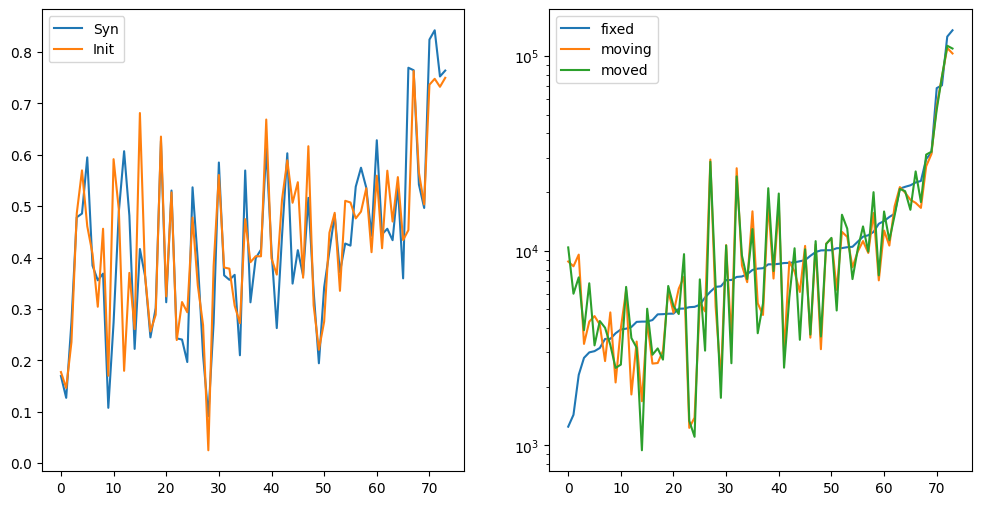

In [25]:
idx = np.argsort(vol_fixed)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(np.array(alldice)[idx], label="Syn")
ax[0].plot(np.array(alldice_init)[idx], label="Init")
ax[0].legend()
idx = np.argsort(vol_fixed)
ax[1].plot(np.array(vol_fixed)[idx], label="fixed")
ax[1].plot(np.array(vol_moving)[idx], label="moving")
ax[1].plot(np.array(vol_moved)[idx], label="moved")
ax[1].set_yscale('log')
ax[1].legend()

In [71]:
# browse_image_slices(saved_deformable[-1][0, 0].data.cpu().numpy())
# browse_image_slices(saved_deformable[-2][0, 0].data.cpu().numpy())

In [358]:
# print(img1.array.max(), img1.array.min())
# print(saved_deformable[-1].max(), saved_deformable[-1].min())

In [10]:
# browse_image_slices(saved_deformable[-1][0, 0].data.cpu().numpy()- moved[-1][0, 0].data.cpu().numpy())
browse_image_slices(saved_deformable[-1][0, 0].data.cpu().numpy())
browse_image_slices(img1.array[0, 0].data.cpu().numpy())
browse_image_slices(img2.array[0, 0].data.cpu().numpy())

interactive(children=(IntSlider(value=91, description='x', layout=Layout(width='600px'), max=181), IntSlider(v…

interactive(children=(IntSlider(value=91, description='x', layout=Layout(width='600px'), max=181), IntSlider(v…

interactive(children=(IntSlider(value=91, description='x', layout=Layout(width='600px'), max=181), IntSlider(v…

In [11]:
from cudants.utils.imageutils import jacobian

# Print values for forward warp
phi = reg.fwd_warp.get_warp() + reg.fwd_warp.grid
jac_v = jacobian(phi, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
print((torch.linalg.det(jac_v) < 0).float().mean(), jac_v.shape)
print((torch.linalg.det(jac_v)).min().item(), torch.linalg.det(jac_v).mean().item(), torch.linalg.det(jac_v).max().item())
print()

# Print values for forward inverse warp
phi = reg.fwd_warp.get_inverse_warp() + reg.fwd_warp.grid
jac_v = jacobian(phi, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
print((torch.linalg.det(jac_v) < 0).float().mean(), jac_v.shape)
print((torch.linalg.det(jac_v)).min().item(), torch.linalg.det(jac_v).mean().item(), torch.linalg.det(jac_v).max().item())
print()

print("Reverse.")

# Print values for reverse warp
phi = reg.rev_warp.get_warp() + reg.rev_warp.grid
jac_v = jacobian(phi, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
print((torch.linalg.det(jac_v) < 0).float().mean(), jac_v.shape)
print((torch.linalg.det(jac_v)).min().item(), torch.linalg.det(jac_v).mean().item(), torch.linalg.det(jac_v).max().item())
print()


phi = reg.rev_warp.get_inverse_warp() + reg.rev_warp.grid
jac_v = jacobian(phi, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
print((torch.linalg.det(jac_v) < 0).float().mean(), jac_v.shape)
print((torch.linalg.det(jac_v)).min().item(), torch.linalg.det(jac_v).mean().item(), torch.linalg.det(jac_v).max().item())

tensor(0., device='cuda:0') torch.Size([1, 180, 216, 180, 3, 3])
0.07706698775291443 0.9945142865180969 6.358409881591797

tensor(0., device='cuda:0') torch.Size([1, 180, 216, 180, 3, 3])
0.1453348696231842 1.0039892196655273 7.333394527435303

Reverse.
tensor(0., device='cuda:0') torch.Size([1, 180, 216, 180, 3, 3])
0.15046408772468567 0.9988133907318115 5.283421516418457

tensor(0., device='cuda:0') torch.Size([1, 180, 216, 180, 3, 3])
0.17986851930618286 1.0007390975952148 6.495911121368408


In [361]:
from cudants.utils.util import compose_warp

0.8672518730163574 0.9998079538345337 1.1405282020568848
torch.Size([1, 126, 114, 94, 3, 3])
0.9081689715385437 0.9999209046363831 1.141826868057251
torch.Size([1, 126, 114, 94, 3, 3])


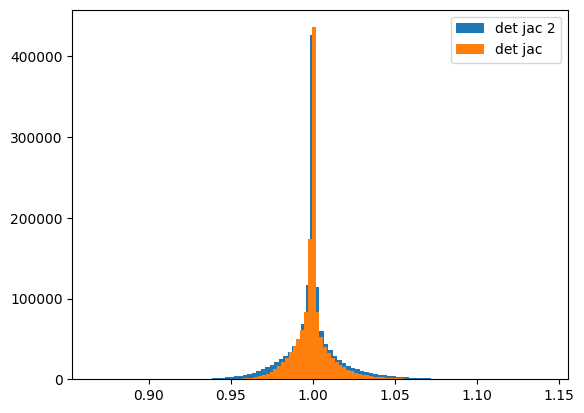

In [362]:
jactest = jacobian(compose_warp(reg.rev_warp.get_inverse_warp(), reg.rev_warp.get_warp(), reg.rev_warp.grid).float() + reg.rev_warp.grid, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
detjactest = torch.linalg.det(jactest)
print(detjactest.min().item(), detjactest.mean().item(), detjactest.max().item())
print(jactest.shape)

_ = plt.hist(detjactest.reshape(-1).detach().cpu().numpy(), bins=100)

jactest = jacobian(compose_warp(reg.rev_warp.get_warp(), reg.rev_warp.get_inverse_warp(), reg.rev_warp.grid).float() + reg.rev_warp.grid, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
detjactest = torch.linalg.det(jactest)
print(detjactest.min().item(), detjactest.mean().item(), detjactest.max().item())
print(jactest.shape)

_ = plt.hist(detjactest.reshape(-1).detach().cpu().numpy(), bins=100)
plt.legend(['det jac 2', 'det jac'])

## Jacobian test

In [363]:
from cudants.utils.imageutils import scaling_and_squaring
from tqdm import tqdm

In [364]:
print(reg.fwd_warp.permute_imgtov)

def compute_inverse_warp(warp, grid, lr=1e-3, iters=200):
    invwarp = nn.Parameter(torch.zeros_like(warp))
    optim = torch.optim.SGD([invwarp], lr=lr,) # momentum=0.0)
    pbar = tqdm(range(iters))
    for i in pbar:
        optim.zero_grad()
        loss = invwarp + F.grid_sample(warp.permute(*reg.fwd_warp.permute_vtoimg), grid + invwarp, mode='bilinear', align_corners=True).permute(*reg.fwd_warp.permute_imgtov)
        loss2 = warp + F.grid_sample(invwarp.permute(*reg.fwd_warp.permute_vtoimg), grid + warp, mode='bilinear', align_corners=True).permute(*reg.fwd_warp.permute_imgtov)
        loss = (loss**2).sum() + (loss2**2).sum()
        loss.backward()
        pbar.set_description(f"iter: {i}, loss: {loss.item()}")
        optim.step()
    return invwarp
    
def compute_inverse_warp_exp(warp, grid, lr=8e-4, iters=50):
    vel = nn.Parameter(torch.zeros_like(warp))
    optim = torch.optim.Adam([vel], lr=lr)
    pbar = tqdm(range(iters))
    for i in pbar:
        optim.zero_grad()
        invwarp = scaling_and_squaring(vel, grid, n=10)
        loss = invwarp + F.grid_sample(warp.permute(*reg.fwd_warp.permute_vtoimg), grid + invwarp, mode='bilinear', align_corners=True).permute(*reg.fwd_warp.permute_imgtov)
        loss2 = warp + F.grid_sample(invwarp.permute(*reg.fwd_warp.permute_vtoimg), grid + warp, mode='bilinear', align_corners=True).permute(*reg.fwd_warp.permute_imgtov)
        loss = (loss**2).sum() + (loss2**2).sum()
        loss.backward()
        pbar.set_description(f"iter: {i}, loss: {loss.item()}")
        optim.step()
    return scaling_and_squaring(vel, grid, n=10)

(0, 2, 3, 4, 1)


In [365]:
# invwarp = compute_inverse_warp_exp(reg.fwd_warp.get_warp().detach(), reg.fwd_warp.grid, lr=5e-3, iters=200)
invwarp = compute_inverse_warp(reg.fwd_warp.get_warp().detach(), reg.fwd_warp.grid, lr=1e-2, iters=500)

iter: 499, loss: 1.683358073234558: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 344.85it/s]


In [366]:
jactest = jacobian(reg.fwd_warp.get_warp() + reg.fwd_warp.grid, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
print(torch.linalg.det(jactest).min().item(), torch.linalg.det(jactest).max().item())
print(jactest.shape)

jactest = jacobian(invwarp.float() + reg.fwd_warp.grid, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
print(torch.linalg.det(jactest).min().item(), torch.linalg.det(jactest).max().item())
print(jactest.shape)

jactest = jacobian(reg.rev_warp.get_warp() + reg.rev_warp.grid, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
print(torch.linalg.det(jactest).min().item(), torch.linalg.det(jactest).max().item())
print(jactest.shape)

0.1576448231935501 7.083554744720459
torch.Size([1, 126, 114, 94, 3, 3])
0.1315915584564209 5.411396026611328
torch.Size([1, 126, 114, 94, 3, 3])
0.26983267068862915 4.475740432739258
torch.Size([1, 126, 114, 94, 3, 3])


In [367]:
### Test invertibility
jactest = jacobian(compose_warp(reg.fwd_warp.get_warp(), invwarp, reg.rev_warp.grid).float() + reg.rev_warp.grid, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
detjactest = torch.linalg.det(jactest)
print(detjactest.min().item(), detjactest.mean().item(), detjactest.max().item())
print(jactest.shape)

jactest = jacobian(compose_warp(invwarp, reg.fwd_warp.get_warp(), reg.rev_warp.grid).float() + reg.rev_warp.grid, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
detjactest = torch.linalg.det(jactest)
print(detjactest.min().item(), detjactest.mean().item(), detjactest.max().item())
print(jactest.shape)

0.5548528432846069 0.9997749924659729 1.3781806230545044
torch.Size([1, 126, 114, 94, 3, 3])
0.6303814053535461 1.0003564357757568 2.306168556213379
torch.Size([1, 126, 114, 94, 3, 3])


In [368]:
jactest = jacobian(compose_warp(reg.fwd_warp.get_warp(), invwarp, reg.rev_warp.grid).float() + reg.rev_warp.grid, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
detjactest = torch.linalg.det(jactest)

jactest2 = jacobian(compose_warp(invwarp, reg.fwd_warp.get_warp(), reg.rev_warp.grid).float() + reg.rev_warp.grid, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
detjactest2 = torch.linalg.det(jactest2)

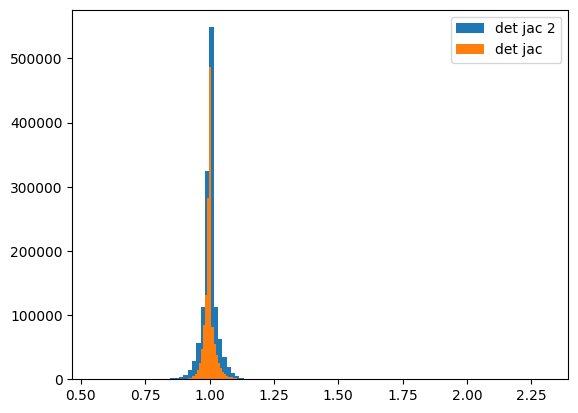

In [369]:
_ = plt.hist(detjactest2.reshape(-1).detach().cpu().numpy(), bins=100)
_ = plt.hist(detjactest.reshape(-1).detach().cpu().numpy(), bins=100)
plt.legend(['det jac 2', 'det jac'])

In [370]:
1/4.416459560394287, 1/0.19380511343479156

(0.22642571189097976, 5.159822577831332)

In [371]:
## compute jacobian of composition
jactest = jacobian(reg.fwd_warp.get_inverse_warp() + reg.fwd_warp.grid, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
print(torch.linalg.det(jactest).min().item(), torch.linalg.det(jactest).max().item())
print(jactest.shape)

## compute jacobian of composition
jactest = jacobian(reg.rev_warp.get_inverse_warp() + reg.rev_warp.grid, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]
print(torch.linalg.det(jactest).min().item(), torch.linalg.det(jactest).max().item())
print(jactest.shape)

-0.14131776988506317 5.019883155822754
torch.Size([1, 126, 114, 94, 3, 3])
0.20922455191612244 3.623750925064087
torch.Size([1, 126, 114, 94, 3, 3])


# Greedy registration

In [15]:
from cudants.registration.deformation.geodesic import GeodesicShooting
from cudants.registration.greedy import GreedyRegistration
reg = GreedyRegistration([8, 4, 2, 1], [200, 200, 100, 50], fixed, moving, 
                        integrator_n=10, init_affine=transform.get_affine_matrix().detach(),
#                          optimizer='SGD', optimizer_lr=10, optimizer_params={'momentum': 0.8},
#                         optimizer='Adam', optimizer_lr=1e-3, optimizer_params={}, 
#                          deformation_type='geodesic',
#                          optimizer_params={'multiply_jacobian': False, 'scaledown': False},
                         deformation_type='compositive', optimizer_lr=0.5, optimizer='Adam',
                         cc_kernel_size = 5,
                         smooth_grad_sigma=1, smooth_warp_sigma=0.1)
saved_deformable = reg.optimize(save_transformed=True)

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [373]:
reg.loss_fn(saved_deformable[-1].cuda(), img1.array.cuda()) / np.prod(img1.array.shape)

tensor(-0.4840, device='cuda:0')

In [374]:
# browse_image_slices(saved_deformable[-1][0, 0].data.cpu().numpy()- moved[-1][0, 0].data.cpu().numpy())
browse_image_slices(saved_deformable[-1][0, 0].data.cpu().numpy())
browse_image_slices(img1.array[0, 0].data.cpu().numpy())
browse_image_slices(img2.array[0, 0].data.cpu().numpy())

interactive(children=(IntSlider(value=64, description='x', layout=Layout(width='600px'), max=127), IntSlider(v…

interactive(children=(IntSlider(value=64, description='x', layout=Layout(width='600px'), max=127), IntSlider(v…

interactive(children=(IntSlider(value=64, description='x', layout=Layout(width='600px'), max=127), IntSlider(v…

In [476]:
from cudants.utils.imageutils import jacobian
phi = reg.warp.get_warp() + reg.warp.grid
jac_v = jacobian(phi, normalize=True).permute(0, 2, 3, 4, 1, 5)[:, 1:-1, 1:-1, 1:-1]

In [477]:
print(jac_v.shape)
detv = torch.linalg.det(jac_v)
# print(detv.shape)
print(detv.min().item(), detv.mean().item(), detv.max().item())

torch.Size([1, 126, 114, 94, 3, 3])
0.008264744654297829 0.9899278879165649 12.22044563293457


In [478]:
print((torch.linalg.det(jac_v) < 0).float().mean())

tensor(0., device='cuda:0')


# Log demons

In [ ]:
from cudants.registration.logdemons import LogDemonsRegistration
reg = LogDemonsRegistration([4, 2, 1], [50, 50, 50], fixed, moving, 
# reg = LogDemonsRegistration([1], [50], fixed, moving,
                eps_prime=0.25, init_affine=transform.get_affine_matrix().detach(),  
                optical_flow_method='gauss-newton', update_sigma=0.1,
                                optical_flow_sigma=0.1, use_lie_bracket=False, symmetric=False)
saved_deformable = reg.optimize(save_transformed=True)

In [ ]:
browse_image_slices(saved_deformable[-1][0, 0].data.cpu().numpy()- moved[-1][0, 0].data.cpu().numpy())
browse_image_slices(saved_deformable[-1][0, 0].data.cpu().numpy())
browse_image_slices(img1.array[0, 0].data.cpu().numpy())
browse_image_slices(img2.array[0, 0].data.cpu().numpy())
# browse_image_slices(moved[-1][0, 0].data.cpu().numpy())

In [ ]:
# browse_image_slices(saved_deformable[-1][0, 0].data.cpu().numpy()- moved[-1][0, 0].data.cpu().numpy())
# browse_image_slices(saved_deformable[-1][0, 0].data.cpu().numpy())
# browse_image_slices(img1.array[0, 0].data.cpu().numpy())
# browse_image_slices(img2.array[0, 0].data.cpu().numpy())
# browse_image_slices(moved[-1][0, 0].data.cpu().numpy())

## Check Optical Flow

In [ ]:
browse_image_slices(reg.velocity_fields[-1][0].data.cpu().numpy() - reg.velocity_fields[-1].min().item())